# Text Modeling with Naive Bayes Lab

## Business Scenario

You've recently joined UrbanTech, a company that develops software for urban transportation systems. As a junior data scientist on the customer experience team, you've been tasked with improving how the company handles user feedback from their mobile app.

UrbanTech has a popular transit navigation app that helps users plan trips using public transportation. The app receives hundreds of user feedback messages daily through its in-app feedback form. Currently, these messages are manually sorted and routed to different teams - a time-consuming process that delays response times and creates inconsistent categorization.

Your manager has asked you to develop a text classification system that can automatically categorize incoming feedback messages into three departments:
1. **Navigation Issues** - Problems with directions, routes, or maps
2. **Service Updates** - Feedback about transit service information accuracy
3. **App Experience** - Issues with the app's functionality or user interface

By implementing an effective text classification model, you'll help UrbanTech respond to user feedback more quickly and consistently, improving both internal efficiency and user satisfaction. You'll focus on using Naive Bayes, a powerful yet interpretable algorithm that works well with limited training data.

## The Process

In this lab, you'll follow these steps to build a text classification system:
1. Data Loading and Exploration
2. Text Preprocessing
3. Feature Extraction
4. Model Building with Naive Bayes
5. Model Evaluation and Comparison
6. Model Improvement
7. Building a Prediction Function

Let's get started!

## Step 0: Setup - Import Libraries

First, let's import all the necessary libraries for our text classification lab.

In [3]:
# Run this cell without changes
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

# For text preprocessing and feature extraction
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# For modeling and evaluation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Set random seed for reproducibility
np.random.seed(42)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\marha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\marha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Step 1: Data Loading and Exploration

Let's load the dataset of user feedback messages and explore its characteristics.

In [5]:
# Run this cell without changes
# Load the feedback data
feedback_data = pd.read_csv('urban_feedback.csv')

# Display the first few rows
feedback_data.head()

,feedback_id,feedback_text,department
0,141,Why does the app need access to my contacts? T...,app_experience
1,114,The station closure information isn't visible ...,service_updates
2,17,The crosswalk at Main and Central is shown in ...,navigation_issues
3,76,The ferry schedule information hasn't been upd...,service_updates
4,156,Every time I try to submit feedback through th...,app_experience


In [6]:
# Run this cell without changes
# Basic information about the dataset
print(f"Dataset shape: {feedback_data.shape}")
print("\nColumn information:")
feedback_data.info()
print(f"\nCategory distribution:\n{feedback_data['department'].value_counts()}")

Dataset shape: (197, 3)

Column information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197 entries, 0 to 196
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   feedback_id    197 non-null    int64 
 1   feedback_text  197 non-null    object
 2   department     197 non-null    object
dtypes: int64(1), object(2)
memory usage: 4.7+ KB

Category distribution:
department
app_experience       66
service_updates      66
navigation_issues    65
Name: count, dtype: int64


In [7]:
# Replace None with your code
# Calculate text length
feedback_data['text_length'] = feedback_data['feedback_text'].str.len()

# Calculate basic statistics of text length by department - hint - use groupby and .describe()
text_length_stats = feedback_data.groupby('department')['text_length'].describe()

Text length statistics by department:
                   count       mean        std   min   25%   50%   75%    max
department                                                                   
app_experience      66.0  73.590909  10.169301  56.0  66.5  72.5  78.0  106.0
navigation_issues   65.0  78.615385  12.458296  53.0  69.0  78.0  86.0  109.0
service_updates     66.0  88.818182  13.205953  69.0  80.0  90.0  95.0  122.0


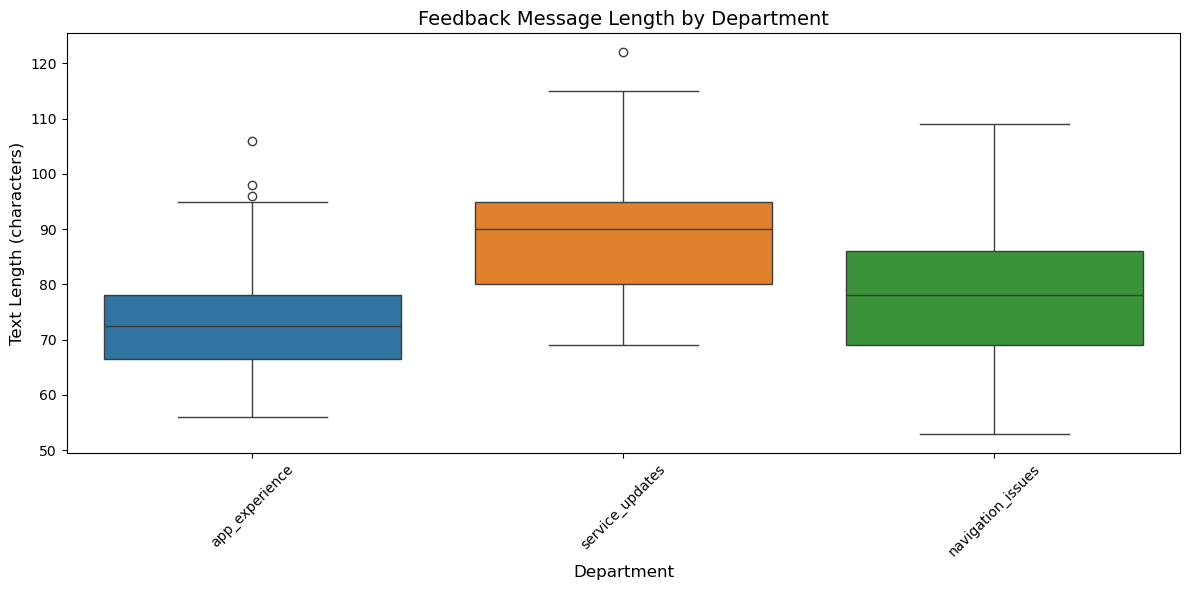

In [8]:
# Run this cell without changes
# Display the statistics
print("Text length statistics by department:")
print(text_length_stats)

# Visualize text length by department
plt.figure(figsize=(12, 6))
sns.boxplot(x='department', y='text_length', data=feedback_data, hue='department', legend=False)
plt.title('Feedback Message Length by Department', fontsize=14)
plt.xlabel('Department', fontsize=12)
plt.ylabel('Text Length (characters)', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Let's also look at some example feedback messages from each department to better understand the data.

In [9]:
# Run this cell without changes
# Display examples from each department
for dept in feedback_data['department'].unique():
    print(f"\nExamples of {dept} feedback:")
    examples = feedback_data[feedback_data['department'] == dept]['feedback_text'].sample(3, random_state=42).values
    for i, example in enumerate(examples, 1):
        print(f"{i}. {example}")


Examples of app_experience feedback:
1. Why does the app need constant location access even when I'm not using it?
2. Why does the app need to access my photos? This seems unnecessary.
3. Why does the app need access to my contacts? This seems like a privacy issue.

Examples of service_updates feedback:
1. The transit system is on a modified schedule today due to the marathon, but this isn't reflected in your app.
2. The weekend service changes aren't reflected in your route suggestions.
3. The station closure information isn't visible until after I've planned a route through it.

Examples of navigation_issues feedback:
1. The waterfront path you suggested is underwater during high tide.
2. The suggested route had me walking through a private shopping mall that closes at 9pm.
3. The crosswalk at Main and Central is shown in the wrong location on your map.


## Step 2: Text Preprocessing

Now, let's create functions to preprocess the text data. This will involve cleaning the text and standardizing it for better feature extraction.

In [10]:
from nltk import pos_tag

# Replace None with your code
def clean_text(text):
    """
    Clean and preprocess text by:
    - Converting to lowercase
    - Removing punctuation and special characters
    - Removing numbers
    
    Parameters:
    -----------
    text : str
        The text to clean
        
    Returns:
    --------
    str
        Cleaned text
    """
    # Convert to lowercase
    text = [word.lower() for word in text]
    
    # Remove punctuation
    cleaned_text = []
    for text in text:
        cleaned = re.sub(r'[^a-zA-Z\s]', '', text)
        if cleaned and not cleaned.isspace():
            cleaned_text.append(cleaned)
    
    return cleaned_text

# Helper function for lemmatization with POS tagging
def get_wordnet_pos(treebank_tag):
    """
    Convert NLTK POS tags to WordNet POS tags
    """
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def tokenize_and_lemmatize(text):
    """
    Tokenize text, remove stopwords, and lemmatize tokens.
    
    Parameters:
    -----------
    text : str
        The text to process
        
    Returns:
    --------
    list
        List of processed tokens
    """
    # Initialize lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # Get stopwords
    stop_words = set(stopwords.words('english'))
    
    # Tokenize text
    tokens = feedback_data['feedback_text'].apply(word_tokenize)
    
    # Tag tokens with parts of speech
    tokens_tagged = pos_tag(tokens)
    
    # Convert to WordNet POS tags
    pos_tokens = [(word[0], get_wordnet_pos(word[1])) for word in tokens_tagged]
    
    # Remove stopwords and lemmatize
    lemmatized_tokens = [lemmatizer.lemmatize(word[0], word[1]) for word in pos_tokens]
    processed_tokens = [lemmatized_token for lemmatized_token in lemmatized_tokens if lemmatized_token not in stop_words]
    
    return processed_tokens

def preprocess_text(text):
    """
    Complete preprocessing pipeline: clean, tokenize, lemmatize, and rejoin.
    
    Parameters:
    -----------
    text : str
        The raw text to process
        
    Returns:
    --------
    str
        Fully processed text
    """
      # Apply cleaning
    cleaned_text = clean_text(text)
    
    # Apply tokenization and lemmatization
    processed_tokens = tokenize_and_lemmatize(cleaned_text)
    
    # Join tokens back into single text string
    processed_text = ' '.join(processed_tokens)
    
    return processed_text

In [11]:
sample_text = feedback_data['feedback_text'].iloc[0]
print(f"Original text:\n{sample_text}")

cleaned_text = clean_text(sample_text)
print(f"\nCleaned text:\n{cleaned_text}")

Original text:
Why does the app need access to my contacts? This seems like a privacy issue.

Cleaned text:
['w', 'h', 'y', 'd', 'o', 'e', 's', 't', 'h', 'e', 'a', 'p', 'p', 'n', 'e', 'e', 'd', 'a', 'c', 'c', 'e', 's', 's', 't', 'o', 'm', 'y', 'c', 'o', 'n', 't', 'a', 'c', 't', 's', 't', 'h', 'i', 's', 's', 'e', 'e', 'm', 's', 'l', 'i', 'k', 'e', 'a', 'p', 'r', 'i', 'v', 'a', 'c', 'y', 'i', 's', 's', 'u', 'e']


In [12]:
# Run this cell without changes
# Test our preprocessing functions on a sample feedback message
sample_text = feedback_data['feedback_text'].iloc[0]
print(f"Original text:\n{sample_text}")

cleaned_text = clean_text(sample_text)
print(f"\nCleaned text:\n{cleaned_text}")

tokens = tokenize_and_lemmatize(cleaned_text)
print(f"\nTokenized and lemmatized text:\n{tokens}")

processed_text = preprocess_text(sample_text)
print(f"\nFully preprocessed text:\n{processed_text}")

Original text:
Why does the app need access to my contacts? This seems like a privacy issue.

Cleaned text:
['w', 'h', 'y', 'd', 'o', 'e', 's', 't', 'h', 'e', 'a', 'p', 'p', 'n', 'e', 'e', 'd', 'a', 'c', 'c', 'e', 's', 's', 't', 'o', 'm', 'y', 'c', 'o', 'n', 't', 'a', 'c', 't', 's', 't', 'h', 'i', 's', 's', 'e', 'e', 'm', 's', 'l', 'i', 'k', 'e', 'a', 'p', 'r', 'i', 'v', 'a', 'c', 'y', 'i', 's', 's', 'u', 'e']


AttributeError: 'list' object has no attribute 'isdigit'

## Step 3: Feature Extraction

Now, let's split our data into training and testing sets, and convert the text into numerical features using different vectorization approaches.

In [16]:
# Replace None with your code
# Split the data into training and testing sets (80% train, 20% test, random_state=42, stratify based on department)
X_train, X_test, y_train, y_test = train_test_split(
   feedback_data['feedback_text'],
   feedback_data['department'],
   test_size=0.2,
   random_state=42,
   stratify=feedback_data['department']  # Ensure balanced classes in both sets
)

# Create and fit a Bag of Words vectorizer (preprocessor=preprocess_text, max_features=50)
count_vectorizer = CountVectorizer(
   lowercase=False,  # Already done in preprocessing
   min_df=2,  # Ignore terms that appear in fewer than 2 documents
   max_df=0.95, # Ignore terms that appear in more than 95% of documents
   ngram_range=(1, 2) # Include both single words and pairs of consecutive words
)

X_train_counts = count_vectorizer.fit_transform(X_train)

# Create and fit a TF-IDF vectorizer (preprocessor=preprocess_text, max_features=50)
tfidf_vectorizer = TfidfVectorizer(
   lowercase=False,
   min_df=2,
   max_df=0.95,
   ngram_range=(1, 2)
)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

In [ ]:
# Run this cell without changes
# Confirm the split
print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")
print(f"\nClass distribution in training set:\n{y_train.value_counts()}")
print(f"\nClass distribution in testing set:\n{y_test.value_counts()}")

# Examine the vocabulary size for each vectorizer (should be 50)
count_vocab_size = len(count_vectorizer.get_feature_names_out())
tfidf_vocab_size = len(tfidf_vectorizer.get_feature_names_out())

print(f"Bag of Words vocabulary size: {count_vocab_size}")
print(f"TF-IDF vocabulary size: {tfidf_vocab_size}")

# Examine the feature matrices
print(f"\nBag of Words feature matrix shape: {X_train_counts.shape}")
print(f"TF-IDF feature matrix shape: {X_train_tfidf.shape}")

# Show the first few feature names
print(f"\nSample of feature names: {count_vectorizer.get_feature_names_out()[:10]}")

## Step 4: Model Building with Naive Bayes

Now, let's build Multinomial Naive Bayes classifiers using both feature representations.

In [ ]:
# Replace None with your code
# Create and train a Multinomial Naive Bayes model with Bag of Words features
nb_bow = MultinomialNB(alpha=1.0)
nb_bow.fit()

# Create and train a Multinomial Naive Bayes model with TF-IDF features
nb_tfidf = None
None

# Function to display the most informative features for each class
def display_top_features(classifier, vectorizer, class_labels, n=5):
    """
    Display the top n most informative features for each class.
    
    Parameters:
    -----------
    classifier : MultinomialNB
        Trained Naive Bayes classifier
    vectorizer : CountVectorizer or TfidfVectorizer
        Fitted vectorizer used to transform the training data
    class_labels : array-like
        List of class labels
    n : int, default=5
        Number of top features to display per class
        
    Returns:
    --------
    dict
        Dictionary mapping class labels to top features
    """
    # Get feature names
    feature_names = None
    
    top_features = {}
    
    # For each class, find the features with highest log probability
    for i, label in enumerate(class_labels):
        # Sort indices by feature log probability
        top_indices = None
        
        # Get the feature names
        top_features[label] = None
        
        # Print the top features
        print(f"\nTop {n} features for class '{label}':")
        for rank, feature in enumerate(top_features[label], 1):
            print(f"{rank}. {feature}")
    
    return top_features

In [ ]:
# Run this cell without changes
# Display top features for the Bag of Words model
print("Top features from Bag of Words model:")
bow_top_features = display_top_features(nb_bow, count_vectorizer, nb_bow.classes_)

# Display top features for the TF-IDF model
print("\nTop features from TF-IDF model:")
tfidf_top_features = display_top_features(nb_tfidf, tfidf_vectorizer, nb_tfidf.classes_)

## Step 5: Model Evaluation and Comparison

Let's evaluate our models on the test set and compare their performance.

In [ ]:
# Replace None with your code
# Transform the test data with both vectorizers
X_test_counts = None
X_test_tfidf = None

# Predict on the test data with both models
y_pred_bow = None
y_pred_tfidf = None

# Function to evaluate a model and display results
def evaluate_model(y_true, y_pred, model_name):
    """
    Evaluate a model and display its performance metrics.
    
    Parameters:
    -----------
    y_true : array-like
        True class labels
    y_pred : array-like
        Predicted class labels
    model_name : str
        Name of the model being evaluated
        
    Returns:
    --------
    float
        Accuracy score
    """
    # Calculate accuracy
    accuracy = None
    
    # Print evaluation results
    print(f"Evaluation for {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    
    # Generate and print classification report
    report = None
    print(f"\nClassification Report:\n{report}")
    
    # Return the accuracy
    return accuracy

In [ ]:
# Run this cell without changes
# Evaluate both models
bow_accuracy = evaluate_model(y_test, y_pred_bow, "Bag of Words + Naive Bayes")
tfidf_accuracy = evaluate_model(y_test, y_pred_tfidf, "TF-IDF + Naive Bayes")

# Create confusion matrices for both models
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Confusion matrix for Bag of Words model
cm_bow = confusion_matrix(y_test, y_pred_bow)
sns.heatmap(cm_bow, annot=True, fmt='d', cmap='Blues', xticklabels=nb_bow.classes_, 
            yticklabels=nb_bow.classes_, ax=axes[0])
axes[0].set_title('Confusion Matrix - Bag of Words Model', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=10)
axes[0].set_ylabel('True Label', fontsize=10)

# Confusion matrix for TF-IDF model
cm_tfidf = confusion_matrix(y_test, y_pred_tfidf)
sns.heatmap(cm_tfidf, annot=True, fmt='d', cmap='Blues', xticklabels=nb_tfidf.classes_, 
            yticklabels=nb_tfidf.classes_, ax=axes[1])
axes[1].set_title('Confusion Matrix - TF-IDF Model', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=10)
axes[1].set_ylabel('True Label', fontsize=10)

plt.tight_layout()
plt.show()

# Compare model accuracies
models = ['Bag of Words + Naive Bayes', 'TF-IDF + Naive Bayes']
accuracies = [bow_accuracy, tfidf_accuracy]

plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=accuracies)
plt.title('Model Accuracy Comparison', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1)
plt.xticks(rotation=15)

# Add accuracy labels to the bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

## Step 6: Model Improvement

Let's try to improve the better model (TF-IDF) by tuning the hyperparameters and refining the feature extraction.

In [ ]:
# Replace None with your code
# Let's perform grid search to tune both vectorizer and model parameters together
# Create a pipeline that combines vectorization and classification - name the steps 'vectorizer' and 'classifier' respectively
text_clf = None

# Define parameter grid to search
# This includes parameters for both the vectorizer and the classifier
param_grid = {
    # Vectorizer type and parameters
    'vectorizer': [count_vectorizer, tfidf_vectorizer],
    
    # Parameters for CountVectorizer and TfidfVectorizer
    'vectorizer__max_features': [50, 100],
    'vectorizer__min_df': [1, 2, 3],
    'vectorizer__max_df': [0.85, 0.9, 0.95],
    'vectorizer__ngram_range': [(1, 1), (1, 2)],
    
    # Classifier parameters
    'classifier__alpha': [0.5, 1.0]
}

# Create a grid search object
grid_search = None

# Fit the grid search to the training data
None

# Use the best estimator to make predictions on the test set
best_model = None
y_pred_grid = None

In [ ]:
# Run this cell without changes
# Evaluate the best model from grid search
# Print the best parameters and score
print("Best Parameters:")
print(grid_search.best_params_)
print(f"\nBest Cross-Validation Score: {grid_search.best_score_:.4f}")

In [ ]:
# Run this cell without changes
# Evaluate the improved model
improved_tfidf_accuracy = evaluate_model(y_test, y_pred_grid, "Improved TF-IDF + Naive Bayes")

## Step 7: Building a Prediction Function

Finally, let's create a function that can take new feedback messages and classify them into the appropriate department. This would be the function that UrbanTech could integrate into their feedback processing system.

In [ ]:
# Replace None with your code
def classify_feedback(feedback_text):
    """
    Classify a new feedback message into the appropriate department.
    
    Parameters:
    -----------
    feedback_text : str
        The raw feedback message to classify
    model : classifier
        Trained classification model
    vectorizer : vectorizer
        Fitted vectorizer to transform the text
        
    Returns:
    --------
    dict
        Dictionary containing classification results
    """
    # Predict the department
    department = None
    
    # Get prediction probabilities
    probabilities = None
    
    # Find the confidence (probability of the predicted class)
    confidence = None
    
    # Create and return the result dictionary
    result = {
        'feedback_text': feedback_text,
        'department': department,
        'confidence': confidence,
        'all_probabilities': dict(zip(best_model.classes_, probabilities[0]))
    }
    
    return result

In [ ]:
# Run this cell without changes
# Test the classification function with new feedback messages
new_feedback = [
    "The app crashed when I tried to view the bus schedule.",
    "Your subway arrival times were completely wrong! The train was 10 minutes late.",
    "I love the new route planning feature, but the app is very slow to load maps.",
    "Can you add more bike routes to the navigation options?", 
    "The bus schedule says the next bus is in 5 minutes, but it's already been 20 minutes and no bus."]

for feedback in new_feedback:
    result = classify_feedback(feedback)
    
    print(f'Feedback: {result['feedback_text']}')
    print(f'Predicted Department: {result['department']}')
    print(f'Confidence: {result['confidence']:.4f}')
    
    # Show all class probabilities
    print('All department probabilities:')
    for dept, prob in result['all_probabilities'].items():
        print(f'  {dept}: {prob:.4f}')

## Conclusion

Congratulations! You've successfully built a text classification system that can automatically categorize user feedback messages for UrbanTech's transit app. In this lab, you've learned how to:

1. Preprocess text data to make it suitable for machine learning
2. Extract features using different vectorization techniques (Bag of Words and TF-IDF)
3. Build and train Multinomial Naive Bayes classifiers for text classification
4. Evaluate and compare model performance using appropriate metrics
5. Tune hyperparameters to improve model performance
6. Create a practical classification function that could be integrated into a production system
7. Package everything into a pipeline for easier deployment

The classification system you've built could significantly improve UrbanTech's ability to handle user feedback efficiently, ensuring that issues are routed to the correct department for prompt resolution. This would enhance the user experience by enabling quicker response times and more consistent handling of feedback.

Remember that in a real-world scenario, you would need to periodically retrain your model with new data to ensure it remains accurate as user feedback patterns change over time.